In [6]:
import tensorflow as tf
import tools.datasets.mnist3 as mnist_tools
import tools.datasets.mnistm as mnistm_tools 
import tools.semisup as semisup
import numpy as np
import architectures as arch
from functools import partial

import tools.visualization as vis
import tools.updated_semisup as up

%load_ext autoreload
%autoreload 2

import sys

mnist_train_images, mnist_train_labels = mnist_tools.get_data('train')
mnist_test_images, mnist_test_labels = mnist_tools.get_data('test')
mnistm_train_images, mnistm_train_labels = mnistm_tools.get_data('train')
mnistm_test_images, mnistm_test_labels = mnistm_tools.get_data('test')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Extracting /home/frankzl/datasets/mnist//train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist//train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist//t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist//t10k-labels-idx1-ubyte.gz


In [7]:
# labeled samples used per class
# sup_per_class = 10
sup_per_class = 1280
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 100
# unlabeled samples per batch
unsup_batch_size = 1000
unsup_samples = -1

learning_rate = 1e-4
decay_steps = 9000
decay_factor = 0.33
logit_weight = 1.0

max_steps = 2000
eval_interval = 500

log_dir = "logs/training/mnist-mnistmK/model"

seed = 1

IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE
NUM_LABELS = mnist_tools.NUM_LABELS

# [10 (classes), 10 (samples), 28, 28, 1]
sup_by_label = semisup.sample_by_label(mnist_train_images, mnist_train_labels,
                        sup_per_class, NUM_LABELS, seed)

visit_weight_envelope = "linear"
visit_weight = 0.6
visit_weight_envelope_steps = 1
visit_weight_envelope_delay = 500

walker_weight_envelope = "linear"
walker_weight = 0.6
walker_weight_envelope_steps = 1
walker_weight_envelope_delay = 500

TARGET_SHAPE = mnistm_tools.IMAGE_SHAPE
TEST_SHAPE   = TARGET_SHAPE

image_shape = IMAGE_SHAPE
new_shape   = TARGET_SHAPE
emb_size    = 128

sampled_unsup_images = mnistm_train_images
sampled_unsup_labels = mnist_train_labels

In [8]:
from ipywidgets import IntProgress, Layout
from train import apply_envelope

graph = tf.Graph()

with graph.as_default():
    
    unsup_data = up.create_input(sampled_unsup_images, sampled_unsup_labels, unsup_batch_size)
    unsup_it   = unsup_data.make_initializable_iterator()
    
    t_unsup_images,t_unsup_labels = unsup_it.get_next()
    
    sup_data,sup_label = up.create_per_class_inputs_v2(sup_by_label, sup_per_batch)
    sup_it             = sup_data.repeat().make_one_shot_iterator()
    sup_it_label       = sup_label.repeat().make_one_shot_iterator()
    
    # Apply augmentation
    def _random_invert(inputs, _):
        randu = tf.random_uniform(
            shape=[sup_per_batch * NUM_LABELS], minval=0.,
            maxval=1.,
            dtype=tf.float32)
        randu = tf.cast(tf.less(randu, 0.5), tf.float32)
        randu = tf.expand_dims(randu, 1)
        randu = tf.expand_dims(randu, 1)
        randu = tf.expand_dims(randu, 1)
        inputs = tf.cast(inputs, tf.float32)
        return tf.abs(inputs - 255 * randu)

    augmentation_function = _random_invert
    
    model_func = partial(
        arch.svhn_model,
        new_shape=new_shape,
        augmentation_function=augmentation_function,
        img_shape=image_shape,
        emb_size=emb_size
    )
    
    model = semisup.SemisupModel(model_func, NUM_LABELS, IMAGE_SHAPE,
                                 test_in=tf.placeholder(np.float32, [None] + TEST_SHAPE, 'test_in')
                                )
    
    t_sup_images, t_sup_labels = tf.concat( sup_it.get_next(), 0), tf.concat( sup_it_label.get_next(), 0)
    
    t_sup_emb   = model.image_to_embedding(t_sup_images)
    t_unsup_emb = model.image_to_embedding(t_unsup_images)
    
    t_sup_logit = model.embedding_to_logit(t_sup_emb)
    
    visit_weight = apply_envelope(
        type = visit_weight_envelope,
        step = model.step,
        final_weight = visit_weight,
        growing_steps = visit_weight_envelope_steps,
        delay = visit_weight_envelope_delay
    )
    
    walker_weight = apply_envelope(
        type = walker_weight_envelope,
        step = model.step,
        final_weight = walker_weight,
        growing_steps = walker_weight_envelope_steps,
        delay = walker_weight_envelope_delay
    )
    
    tf.summary.scalar("Weights_Visit", visit_weight)
    tf.summary.scalar("Weight_Walker", walker_weight)
    
    model.add_logit_loss(t_sup_logit, t_sup_labels, weight=logit_weight)
    
    #model.add_semisup_loss(t_sup_emb, t_unsup_emb, t_sup_labels, visit_weight=visit_weight, walker_weight=walker_weight)
    equality_matrix = tf.equal(tf.reshape(t_sup_labels, [-1, 1]), t_sup_labels)
    equality_matrix = tf.cast(equality_matrix, tf.float32)
    p_target = (equality_matrix / tf.reduce_sum(
        equality_matrix, [1], keepdims=True))

    embedding_dim = t_sup_emb.shape[1]
    reshaped_semb = tf.reshape( t_sup_emb, [-1, 1, embedding_dim] )
    reshaped_uemb = tf.reshape( t_unsup_emb, [-1, 1, embedding_dim] )
    
    stacked_semb = tf.stack(unsup_batch_size*[t_sup_emb], 1)
    stacked_uemb = tf.stack(sup_per_batch*NUM_LABELS*[t_unsup_emb], 1)
    
    uemb_T = tf.transpose(stacked_uemb, perm=[1,0,2])
     
    sigma = 20
    pairwise_dist = (stacked_semb - uemb_T)#, axis=2)
    pairwise_norm = tf.norm( pairwise_dist, axis=2)
    pairwise_sq   = tf.square(pairwise_norm)
    
    
    division = - tf.divide( pairwise_sq, tf.constant(2*sigma**2, dtype=tf.float32))
    
    match_ab   = tf.exp(division, name='match_ab')
    
    p_ab = tf.nn.softmax(match_ab, name='p_ab')
    p_ba = tf.nn.softmax(tf.transpose(match_ab), name='p_ba')
    p_aba = tf.matmul(p_ab, p_ba, name='p_aba')

    model.create_walk_statistics(p_aba, equality_matrix)
    
    loss_aba = tf.losses.softmax_cross_entropy(
        p_target,
        tf.log(1e-8 + p_aba),
        weights=walker_weight,
        scope='loss_aba')
    model.add_visit_loss(p_ab, visit_weight)

    pairwise_dt, mab_dt, pab_dt, paba_dt, semb_dt, uemb_dt = tf.gradients([loss_aba], [pairwise_sq, match_ab, p_ab, p_aba, t_sup_emb, t_unsup_emb])
    
    tf.summary.scalar('Loss_aba', loss_aba)
    
    t_learning_rate = tf.train.exponential_decay(
        learning_rate,
        model.step,
        decay_steps,
        decay_factor,
        staircase = True
    )
    
    train_op = model.create_train_op(t_learning_rate)
    summary_op = tf.summary.merge_all()
    
    summary_writer = tf.summary.FileWriter(log_dir, graph)
    
    saver = tf.train.Saver(max_to_keep=30)

---------
Variables: name (type shape) [size]
---------
net/conv1/weights:0 (float32_ref 3x3x3x32) [864, bytes: 3456]
net/conv1/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_2/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_2/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv1_3/weights:0 (float32_ref 3x3x32x32) [9216, bytes: 36864]
net/conv1_3/biases:0 (float32_ref 32) [32, bytes: 128]
net/conv2_1/weights:0 (float32_ref 3x3x32x64) [18432, bytes: 73728]
net/conv2_1/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_2/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_2/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv2_3/weights:0 (float32_ref 3x3x64x64) [36864, bytes: 147456]
net/conv2_3/biases:0 (float32_ref 64) [64, bytes: 256]
net/conv3/weights:0 (float32_ref 3x3x64x128) [73728, bytes: 294912]
net/conv3/biases:0 (float32_ref 128) [128, bytes: 512]
net/conv3_2/weights:0 (float32_ref 3x3x128x128) [147456, bytes: 589824]
net/conv3_2/biases:

In [9]:
import time
import datetime
log_dir

test_images = mnistm_test_images[:2000]
test_labels = mnistm_test_labels[:2000]

In [5]:
test_images = mnistm_test_images[:2000]
test_labels = mnistm_test_labels[:2000]


from IPython.display import display

max_steps = 1502
f = IntProgress(min=0, max=max_steps, layout= Layout(width="100%")) # instantiate the bar
display(f) # display the bar

sesh = tf.Session(graph = graph, config=tf.ConfigProto(intra_op_parallelism_threads=2, allow_soft_placement=True))

eval_interval = 100

with sesh as sess:
    
    sess.run(unsup_it.initializer)
    sess.run(tf.global_variables_initializer())
    
    epoch = 0
    
    for step in range(0, max_steps):
        t0 = time.time()
        try:
            loss, _, summaries = sess.run([model.train_loss, train_op, summary_op])
        except tf.errors.OutOfRangeError:
            sess.run(unsup_it.initializer)
            epoch += 1
            
            loss, _, summaries = sess.run([model.train_loss, train_op, summary_op])
           
        f.value = step
        f.description = f"Ep{epoch}:{step}/{max_steps}"
        if (step) % eval_interval == 0:
            
            t1 = time.time()
            print(f"Time left: {datetime.timedelta(seconds=int((t1-t0)*(max_steps-step)))}s")
            
            print('Step: %d' % step)
            test_pred = model.classify(test_images).argmax(-1)
            conf_mtx = semisup.confusion_matrix(test_labels, test_pred, NUM_LABELS)
            test_err = (test_labels != test_pred).mean() * 100
            print(conf_mtx)
            print('Test error: %.2f %%' % test_err)
            print(f'Loss: {loss}')
    
            test_summary = tf.Summary(
                value=[tf.Summary.Value(
                    tag='Test Err', simple_value=test_err)])
    
            summary_writer.add_summary(summaries, step)
            summary_writer.add_summary(test_summary, step)

            print(f"saving model - step {step}")
            print()
            saver.save(sess, log_dir, global_step=model.step)

IntProgress(value=0, layout=Layout(width='100%'), max=1502)

Time left: 8:54:11s
Step: 0
[[ 17   3  63  10   2  80   0   0   0   0]
 [  4   5 138  15  16  55   1   0   0   0]
 [  8   2 131  16   9  52   1   0   0   0]
 [  9   2 109  22   5  59   1   0   0   0]
 [  5   4 110  12  11  75   0   0   0   0]
 [  6   3  84   9  10  67   0   0   0   0]
 [  6   3  93  19   8  49   0   0   0   0]
 [  5   3 119  13   6  59   0   0   0   0]
 [ 11   1  80  25   7  67   1   0   0   0]
 [  7   4  89  17   3  74   0   0   0   0]]
Test error: 87.35 %
Loss: 2.3442230224609375
saving model - step 0

Time left: 8:14:36s
Step: 100
[[117   3  10  11   2   8   8   3  11   2]
 [  7 126  10  10  29   3   6  20  20   3]
 [ 10   2 137  20  16   3   6  10  12   3]
 [ 15   6  24 103  13  13   1  11  20   1]
 [  4   2  10  14 131   7   8  17  17   7]
 [  8   2   4  22  13 101  11   5  10   3]
 [  7   4   7  19  14   7 110   1   8   1]
 [  3   1  12  14  15   4   2 138   8   8]
 [ 20   3  10  25  19  10  12  12  76   5]
 [ 11   0   4  21  37  10   5  22  15  69]]
Test error: 

In [10]:
all_steps = list(range(1,1502,100))

p_aba_list = []
match_ab_list = []
p_ab_list = []
semb_list = []
uemb_list = []
slabel_list = []
ulabel_list = []

for train_step in all_steps:
    model_checkpoint = f"{log_dir}-{train_step}"

    with tf.Session(graph=graph) as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, model_checkpoint)
        
        sess.run(unsup_it.initializer)
        
        pab, slabel, ulabel, ab, aba, semb, uemb = sess.run([p_ab, t_sup_labels, t_unsup_labels, match_ab, p_aba, t_sup_emb, t_unsup_emb])
        p_aba_list.append(aba)
        match_ab_list.append(ab)
        p_ab_list.append(pab)
        semb_list.append(semb)
        uemb_list.append(uemb)
        slabel_list.append(slabel)
        ulabel_list.append(ulabel)

INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-1
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-101
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-201
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-301
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-401
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-501
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-601
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-701
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-801
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-901
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-1001
INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-1101
INFO:tensorflow:Restoring parameters fro

In [11]:
sorted_uemb_list     = []
sorted_match_ab_list = []

from scipy.special import softmax

for idx in range(len(uemb_list)):
    sorted_uemb_list.append(uemb_list[idx][ulabel_list[idx].argsort()])
    sorted_match_ab_list.append(match_ab_list[idx][:,ulabel_list[idx].argsort()])

In [12]:

from ipywidgets import IntSlider, RadioButtons
from IPython.html.widgets import *
import matplotlib.pyplot as plt

def plot_img(array, step):
    if array == 0:
        a = p_aba_list
    elif array == 1:
        a = match_ab_list
    else:
        a = sorted_match_ab_list
            
    fig = plt.figure()
    plt.imshow(a[(step-1)//100])

interact(
    lambda step, array: plot_img(array, step),
    step = IntSlider(
        value=901,
        min=1,
        max=1501,
        step=100,
        description='Train Step',
        continuous_update=True,
        orientation='horizontal',
    ),
    array = RadioButtons(
        options=[('p_aba', 0), ("match_ab", 1), ("sorted_match_ab", 2)],
    )
)

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(IntSlider(value=901, description='Train Step', max=1501, min=1, step=100), RadioButtons(…

<function __main__.<lambda>(step, array)>

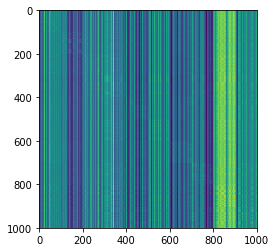

In [32]:
plt.imshow(softmax(match_ab_list[7], axis=1) @ softmax(match_ab_list[7].T, axis=1))

In [9]:
def print_gradient_info(idx):
    with tf.Session(graph=graph) as sess:
        saver = tf.train.Saver()
        
        model_checkpoint = f"{log_dir}-{idx}"
        saver.restore(sess, model_checkpoint)
        sess.run(unsup_it.initializer)
        
        test_pred = model.classify(test_images).argmax(-1)
        
        pair_dist, pair_dt, uemb, semb, laba, mabgr, pabgr, pabagr, sgr, ugr = sess.run([pairwise_sq, pairwise_dt, t_unsup_emb, t_sup_emb, loss_aba, mab_dt, pab_dt, paba_dt, semb_dt, uemb_dt])
    print("uemb", end="")
    print(uemb)
    print("semb", end="")
    print(semb)
    print("p aba gradient", end="")
    print(pabagr)
    print("loss aba", end="")
    print(laba)
    print("match ab gradient", end="")
    print(mabgr)
    print("p ab gradient", end="")
    print(pabgr)
    print("sup emb grad", end="")
    print(sgr)
    print("unsup emb grad", end="")
    print(ugr)
    
    return [pair_dist, pair_dt, uemb, semb, laba, mabgr, pabgr, pabagr, sgr, ugr]

_ = print_gradient_info(401)

INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-401
uemb[[-0.94394886 -0.7184788  -0.99900275 ...  3.445134    0.1862248
   1.274286  ]
 [ 2.8143125  -0.95462704 -0.857358   ...  9.484954   -0.6523144
   0.3724179 ]
 [-0.80235755 -0.96546847  2.2383287  ...  3.737493    4.418474
   3.2411108 ]
 ...
 [ 0.8232553  -0.79149234 -0.6606943  ...  1.8894536   2.0529673
   1.7942973 ]
 [ 1.9679959  -0.7134252   2.1969378  ...  7.301764    0.6056422
   3.1742253 ]
 [-0.3493725   1.180385    0.46371692 ... 11.928965   -0.79607975
   3.8662047 ]]
semb[[-0.6675752  -0.25231892 -0.6569177  ...  5.400612    1.021112
   1.1862195 ]
 [ 0.98510766 -0.7683648  -0.28444362 ...  5.7504535   2.4343483
   0.6474108 ]
 [ 1.1706226   1.1811109  -0.46639633 ...  4.581823    0.34646913
  -0.5181669 ]
 ...
 [ 1.9378693   2.32865     2.668963   ...  5.1039567  -0.45387858
   0.3241894 ]
 [ 3.1845608   1.7043327   2.109577   ...  5.603824   -0.08570629
  -0.28031123]
 [-0.1124593  -0.05

In [10]:
info = print_gradient_info(601)

INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-601
uemb[[ 6.6394453e+00 -9.2292261e-01 -9.9333924e-01 ...  2.8373470e+00
  -4.6842945e-01  5.0728196e-01]
 [-6.6645145e-03 -9.0811729e-01 -9.7957683e-01 ...  2.2555490e+00
   1.3523031e+00  1.5838701e+00]
 [-8.0669945e-01  2.3593099e+00  3.8726227e+00 ...  4.5857062e+00
  -9.2238528e-01 -3.0079472e-01]
 ...
 [ 4.3793291e-02  3.8017681e+00 -9.4712961e-01 ...  6.8645067e+00
  -9.9835896e-01 -9.9944037e-01]
 [-9.9950671e-01 -9.4368565e-01 -8.1766176e-01 ...  7.0230043e-01
   5.8532839e+00  2.4627979e+00]
 [ 1.2868508e+00 -8.9611810e-01 -8.0334258e-01 ...  3.5062404e+00
   5.0632915e+00  1.8073223e+00]]
semb[[-0.99981135  3.3683355  -0.90987545 ...  5.8247766  -0.63805765
   4.7064686 ]
 [ 1.7653381  -0.8214669  -0.5606079  ...  5.8667994   0.9519479
   1.214448  ]
 [-0.16234869 -0.97033644 -0.98125774 ...  4.660941   -0.2844391
   0.485102  ]
 ...
 [-0.53317595 -0.9197204   5.765381   ...  1.5511276  -0.86879987


In [40]:
info[0]

array([[1739.6111 , 2909.5073 , 1783.8961 , ..., 2038.1514 , 1496.1031 ,
        2074.376  ],
       [2422.227  , 3366.3647 , 1345.7893 , ..., 1542.4392 , 1279.6738 ,
        1597.2924 ],
       [2425.5981 , 3380.649  , 1077.0785 , ..., 1470.9055 , 1362.6464 ,
        1842.2802 ],
       ...,
       [1852.9225 , 3021.3147 , 2394.046  , ..., 2200.7954 , 1153.8726 ,
        2126.0798 ],
       [ 747.85205, 2990.0642 , 2621.5925 , ..., 2254.8315 , 1359.7538 ,
        2484.3767 ],
       [1030.6482 , 2832.0076 , 2419.4753 , ..., 2568.4453 , 1506.0897 ,
        2577.5225 ]], dtype=float32)

In [46]:
uemb = info[2]

In [47]:
semb = info[3]

In [53]:
np.linalg.norm(semb[5] - semb[0])**2

1461.2549150383566

In [87]:
info[1]

array([[-1.7355395e-11, -1.0996655e-12,  9.3304817e-12, ...,
         8.2814051e-13, -9.8798790e-12, -1.8108293e-12],
       [-6.0674586e-12, -3.1701291e-13,  2.2618400e-11, ...,
         5.1892679e-12, -8.8414050e-12, -3.6314528e-13],
       [-6.7065359e-12, -5.3800524e-13,  2.7996916e-11, ...,
         2.6866599e-12, -1.1085989e-11, -1.9933035e-12],
       ...,
       [ 3.0863242e-12, -5.4450314e-13, -2.3374605e-12, ...,
        -3.0293060e-12, -2.9174833e-12, -4.0234062e-12],
       [ 1.5837507e-11, -5.6760792e-13, -1.7387988e-12, ...,
        -2.8294112e-12, -2.1518286e-12, -2.5092185e-12],
       [ 1.0647620e-11, -6.3623613e-13, -2.1657472e-12, ...,
        -1.7952342e-12, -1.3779628e-12, -2.1445103e-12]], dtype=float32)

In [123]:
-np.exp( - info[0] / (2*20**2) ) * info[5]

array([[-3.2339420e-09, -3.7880510e-10, -6.6815681e-10, ...,
         1.0017246e-09, -4.4242401e-09, -3.7314187e-09],
       [-2.9881881e-09, -4.2953416e-10, -1.0132147e-10, ...,
         2.4415083e-09, -5.0540203e-09, -3.1175931e-09],
       [-5.3510760e-09, -4.7868962e-09, -2.7649497e-10, ...,
        -1.2709079e-09, -9.5310870e-09, -8.5575582e-09],
       ...,
       [ 2.1668753e-09,  1.4419528e-10, -7.7434871e-11, ...,
         3.1835548e-09,  1.2483889e-08,  1.0894600e-08],
       [ 4.7638684e-09,  3.1473192e-12, -1.8601956e-10, ...,
         1.6238849e-09,  2.1670882e-08,  3.5999546e-09],
       [ 5.7190599e-09,  4.2918727e-10, -7.9575818e-11, ...,
         1.9760757e-09,  2.2238822e-08,  3.5872412e-09]], dtype=float32)

In [117]:
info[5]

array([[ 4.8881112e-08,  4.4940149e-09,  1.7828780e-08, ...,
        -8.2867704e-09,  5.2601550e-08,  5.2143168e-08],
       [ 4.7254964e-08,  3.3213041e-09,  1.5745131e-08, ...,
        -1.0856523e-08,  5.1778677e-08,  5.0220713e-08],
       [ 6.2485498e-08,  2.1265734e-08,  2.9581061e-08, ...,
         6.7888037e-09,  6.8742125e-08,  6.8133531e-08],
       ...,
       [-3.1600194e-08, -9.7005692e-10,  8.2763920e-09, ...,
        -2.2514470e-08, -7.6529261e-08, -5.0701967e-08],
       [-3.2474595e-08, -3.8469061e-11,  9.4998907e-09, ...,
        -2.0276410e-08, -8.2510212e-08, -4.3634586e-08],
       [-3.9387842e-08, -6.1869563e-09,  3.7797649e-09, ...,
        -2.6545692e-08, -8.9520555e-08, -4.9804875e-08]], dtype=float32)

In [6]:
idx = 601
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver()
    
    model_checkpoint = f"{log_dir}-{idx}"
    saver.restore(sess, model_checkpoint)
    sess.run(unsup_it.initializer)
    
    test_pred = model.classify(test_images).argmax(-1)
    
    paba_t = sess.run(p_target)

INFO:tensorflow:Restoring parameters from logs/training/mnist-mnistmK/model-601


In [7]:
info[]

array([[0.01, 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
       [0.01, 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
       [0.01, 0.01, 0.01, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.01, 0.01, 0.01],
       [0.  , 0.  , 0.  , ..., 0.01, 0.01, 0.01],
       [0.  , 0.  , 0.  , ..., 0.01, 0.01, 0.01]], dtype=float32)